In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 

import os

from fastai.vision.all import *
from fastai.text.all import *
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

import torchtext
from torchtext.data import get_tokenizer 
from collections import Counter    
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
import PIL
from PIL import Image
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
captions_path = "/content/gdrive/MyDrive/dataset/captions_withcomma.txt"
images_path = "/content/gdrive/MyDrive/dataset/Images/"

In [ ]:
df = pd.read_csv(captions_path)

print(f"No of captions: {len(df)}")
df.head()

No of captions: 40450


,image,caption
0,1000268201_693b08cb0e,गुलाबी पोशाक में एक बच्चा प्रवेश के रास्ते में सीढ़ियों के एक सेट पर चढ़ रहा है।
1,1000268201_693b08cb0e,एक लड़की लकड़ी की इमारत में जा रही है।
2,1000268201_693b08cb0e,एक छोटी लड़की लकड़ी के प्लेहाउस में चढ़ गई।
3,1000268201_693b08cb0e,एक छोटी सी लड़की अपने प्लेहाउस में सीढ़ियाँ चढ़ रही थी।
4,1000268201_693b08cb0e,एक गुलाबी पोशाक में एक छोटी लड़की एक लकड़ी के केबिन में जा रही है।


In [ ]:
class my_dictionary(dict): 
    def __init__(self): 
        self = dict() 
    def add(self, key, value): 
        if key not in self.keys():
            self[key] = [value]
        else:
            self[key].append(value)
        
descriptors = my_dictionary()

In [ ]:
for i in range(len(df)):
    img_id = df.iloc[i, 0] + ".jpg"
    sentence = ("<start> " + df.iloc[i, 1] + " <end>").split()
    
    descriptors.add(img_id, sentence)

In [ ]:
print(descriptors['1001773457_577c3a7d70.jpg'])

[['<start>', 'एक', 'काला', 'कुत्ता', 'और', 'एक', 'चित्तीदार', 'कुत्ता', 'लड़', 'रहे', 'हैं', '<end>'], ['<start>', 'एक', 'काला', 'कुत्ता', 'और', 'सड़क', 'पर', 'एक', 'दूसरे', 'के', 'साथ', 'खेलता', 'हुआ', 'एक', 'तिरंगा', 'कुत्ता।', '<end>'], ['<start>', 'एक', 'काले', 'कुत्ते', 'और', 'भूरे', 'रंग', 'के', 'धब्बे', 'वाला', 'एक', 'सफेद', 'कुत्ता', 'सड़क', 'पर', 'एक', 'दूसरे', 'को', 'घूर', 'रहा', 'है।', '<end>'], ['<start>', 'सड़क', 'पर', 'एक-दूसरे', 'को', 'देख', 'अलग-अलग', 'नस्लों', 'के', 'दो', 'कुत्ते।', '<end>'], ['<start>', 'फुटपाथ', 'पर', 'दो', 'कुत्ते', 'एक', 'दूसरे', 'की', 'ओर', 'बढ़ते', 'हुए।', '<end>']]


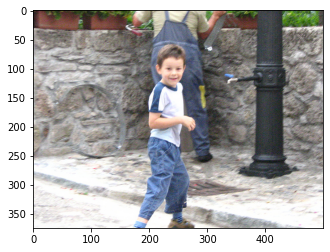

एक छोटा लड़का सड़क पर खड़ा है जबकि चौग़ा में एक आदमी पत्थर की दीवार पर काम कर रहा है।


In [ ]:
image_indx = 41
image_path = images_path + df.iloc[image_indx, 0] + '.jpg'
img = Image.open(image_path)
plt.imshow(img)
plt.show()
for i in range(image_indx, image_indx+1):
    print(df.iloc[i, 1])

In [ ]:
tokenizer = get_tokenizer("basic_english")
token_counter = Counter()

In [ ]:
class textVocab:
    def __init__(self):
        self.itos = {0:"<PAD>", 1:"<start>", 2:"<end>", 3:"<UNK>"} 
        self.stoi = {b:a for a, b in self.itos.items()}
        self.min_freq = 1
        self.tokenizer = get_tokenizer("basic_english")
        self.token_counter = Counter()

    #length of vocabulary
    def __len__(self):
        return len(self.itos)
      
    #tokenizing
    def tokenize(self, text):
        return self.tokenizer(text)
    
    # numericalization
    def numericalize(self, text):
        tokens_list = self.tokenize(text)
        
        ans = []
        for token in tokens_list:
            if token in self.stoi.keys():
                ans.append(self.stoi[token]) 
            else:
                ans.append(self.stoi["<UNK>"])
        return ans
    def build_vocab(self, sentence_list):
        word_count = 4
        for sentence in sentence_list:
            tokens = self.tokenizer(sentence)
            token_counter.update(tokens)
            
            for token in tokens:
                if token_counter[token] >= self.min_freq and token not in self.stoi.keys():
                    self.stoi[token] = word_count
                    self.itos[word_count] = token
                    word_count += 1

In [ ]:
inception = models.inception_v3(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
class MyInceptionFeatureExtractor(nn.Module):
    def __init__(self, inception, transform_input=False):
        super(MyInceptionFeatureExtractor, self).__init__()
        self.transform_input = transform_input
        self.Conv2d_1a_3x3 = inception.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = inception.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = inception.Conv2d_2b_3x3
        
        self.maxpool1 = inception.maxpool1
        self.Conv2d_3b_1x1 = inception.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = inception.Conv2d_4a_3x3
        self.maxpool2 = inception.maxpool2
        
        self.Mixed_5b = inception.Mixed_5b
        self.Mixed_5c = inception.Mixed_5c
        self.Mixed_5d = inception.Mixed_5d
        self.Mixed_6a = inception.Mixed_6a
        self.Mixed_6b = inception.Mixed_6b
        self.Mixed_6c = inception.Mixed_6c
        self.Mixed_6d = inception.Mixed_6d
        self.Mixed_6e = inception.Mixed_6e
        
        self.AuxLogits = inception.AuxLogits
        
        self.Mixed_7a = inception.Mixed_7a
        self.Mixed_7b = inception.Mixed_7b
        self.Mixed_7c = inception.Mixed_7c

    def forward(self, x):
        
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = self.maxpool1(x)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192
        x = self.maxpool2(x)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 17 x 17 x 768
        x = self.Mixed_5c(x)
        # 17 x 17 x 768
        x = self.Mixed_5d(x)
        # 17 x 17 x 768
        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        
        return x

In [ ]:
class customDataset(Dataset):
    def __init__(self, image_dir, captions_file, transform=None, min_freq=5):
        self.image_dir = image_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform
        
        # get image ids and captions 
        self.img_ids = self.df["image"]
        self.sentences = self.df["caption"]
        
        # initializing vocabulary function
        self.vocab = textVocab()
        
        # create vocabulary
        self.vocab.build_vocab(self.sentences.tolist())
        
    def __len__(self):
        return len(self.df)
    
    # method to return pair of input and output data
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        img_id = self.img_ids[idx] + '.jpg'
        img_path = os.path.join(self.image_dir, img_id)
        img = Image.open(img_path).convert("RGB")
        
        # apply transformation on image(resize)
        if self.transform is not None:
            img = self.transform(img)

        vec = []
        
        vec += [self.vocab.stoi["<start>"]]   # tagging
        vec += self.vocab.numericalize(sentence)  # numericalization
        vec += [self.vocab.stoi["<end>"]]     # tagging
        
        # return text vector and image tensor
        return img, torch.tensor(vec), img_id

In [ ]:
# defining the transforms
inception_Transform = T.Compose([
    T.Resize(299),
    T.CenterCrop(299),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
transforms = inception_Transform

In [ ]:
transforms

Compose(
    Resize(size=299, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(299, 299))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [ ]:
dataset = customDataset(
    image_dir = images_path,
    captions_file = captions_path,
    transform = transforms
)

In [ ]:
with open('vocab.pkl', 'wb') as file:
    pickle.dump(dataset.vocab, file)

In [ ]:
validation_split = .1
shuffle_dataset = False
random_seed= 42

In [ ]:
dataset_size = len(dataset)
indices = list(range(dataset_size))

# find the split point
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

# shuffle the dataset
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

In [ ]:
def show_image(img, title=None):
    
    # unnormalize
    img[0] *= 0.229
    img[1] *= 0.224
    img[2] *= 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

2355880294_8f78a6fea6.jpg


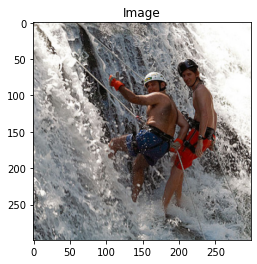

caption:  ['<start>', 'एक', 'झरने', 'के', 'ऊपर', 'रस्सी', 'से', 'लटकते', 'दो', 'आदमी।', '<end>']


In [ ]:


# get an item from dataset
img, vec, img_id = dataset[8083]
print(img_id)
show_image(img, "Image")

# to convert returned vector into sentence
caption = [dataset.vocab.itos[token] for token in vec.tolist()]
print("caption: ", caption)



In [ ]:
#merge samples
class Collate_fn:
    def __init__(self, pad_value, batch_first=False):
        self.pad_value = pad_value       # initialize padding value
        self.batch_first = batch_first    
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)

        captions = [item[1] for item in batch]
        
        # do padding on all text vectors   
        captions = pad_sequence(captions, batch_first = self.batch_first, padding_value = self.pad_value)
        img_ids = [item[2] for item in batch]
        
        return imgs, captions, img_ids

In [ ]:
batch_size = 64
pad_value = dataset.vocab.stoi["<PAD>"] #pad_value=0

In [ ]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [ ]:
dls = torch.utils.data.DataLoader(dataset, 
                                           batch_size=batch_size, shuffle=False,
                                           collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, shuffle=False,
                                                batch_size=batch_size,
                                                collate_fn = Collate_fn(pad_value=pad_value, batch_first = True),
                                                sampler=valid_sampler)

काले और भूरे रंग के कुत्ते सफेद समर्थन के साथ बाधा पर कूदते हैं।


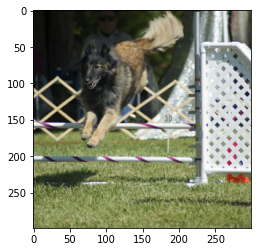

In [ ]:
# dataloader iterator
dlsItr = iter(dls)
batch = next(dlsItr)
imgs, captions, img_ids = batch
for i in range(batch_size):
    img, caption = imgs[i], captions[i]
    sentence = [dataset.vocab.itos[token] for token in caption.tolist()]
    end_indx = sentence.index('<end>')
    sentence = sentence[1:end_indx]
    sentence = ' '.join(sentence)
    
    print(sentence)
    show_image(img)
    plt.show()
    
    break

In [ ]:
inception = models.inception_v3(pretrained=True)

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.my_inception = MyInceptionFeatureExtractor(inception)
        
    def forward(self, images):
        features = self.my_inception(images) 
        features = features.permute(0, 2, 3, 1)
        features = features.view(features.size(0), -1, features.size(-1))
        return features

In [ ]:
class Attention(nn.Module):
    
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.attention_dim = attention_dim
        self.decoder_att = nn.Linear(decoder_dim, attention_dim) 
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
    def forward(self, features, hidden_states):
        att1 = self.encoder_att(features)   
        att2 = self.decoder_att(hidden_states)
        combined_states = torch.tanh(att1 + att2.unsqueeze(1))
        attention_scores = self.full_att(combined_states)
        attention_scores = attention_scores.squeeze(2)
        

        alpha = F.softmax(attention_scores, dim=1)
        
        weighted_encoding = features * alpha.unsqueeze(2)  
        weighted_encoding = weighted_encoding.sum(dim=1)   
        return alpha, weighted_encoding
        

In [ ]:
class Decoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        self.vocab_sz = vocab_sz
        self.att_dim = att_dim
        self.dec_dim = dec_dim
        
        # initializing embedding model and attention model
        self.embedding = nn.Embedding(vocab_sz, embed_sz)
        self.attention = Attention(enc_dim, dec_dim, att_dim)
        
        # creating the hidden and cell state
        self.init_h = nn.Linear(enc_dim, dec_dim)
        self.init_c = nn.Linear(enc_dim, dec_dim)
        
        # creating lstm cell
        self.lstm_cell = nn.LSTMCell(embed_sz + enc_dim, dec_dim, bias=True)
        
        # creating other nn layers
        self.f_beta = nn.Linear(dec_dim, enc_dim)
        self.fcn = nn.Linear(dec_dim, vocab_sz)
        self.drop = nn.Dropout(drop_prob)
    
    def forward(self, features, captions):
        
        # vectorize the captions(tokenized)
        embeds = self.embedding(captions)
        
        # initialize hidden and cell state
        h, c = self.init_hidden_state(features)
        
        # get the captions length in current batch
        cap_len = len(captions[0]) - 1
        
        # get batch size and features size
        batch_sz = captions.size(0)
        num_features = features.size(1)
        
        # create tensor of zeros for predictions and alpha
        preds = torch.zeros(batch_sz, cap_len, self.vocab_sz).to(device)
        alphas = torch.zeros(batch_sz, cap_len, num_features).to(device)
        
        for i in range(cap_len):
            # get alpha and attention weights
            alpha, att_weights = self.attention(features, h)
            
            # create lstm input
            lstm_input = torch.cat((embeds[:,i], att_weights), dim=1)
            
            # pass through lstm cell
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through linear layer
            output = self.fcn(self.drop(h))
            
            # store the output and alpha
            preds[:, i] = output
            alphas[:, i] = alpha
            
        return preds, alphas
    
    # create method to generate captions
    def generate_caption(self, features, max_len=20, vocab=None):
        batch_sz = features.size(0)
        
        # hidden and cell state
        h, c = self.init_hidden_state(features)
        
        alphas = []
        captions = [vocab.stoi['<start>']]
        
        # starting input
        word = torch.tensor(vocab.stoi['<start>']).view(1, -1).to(device)
        embeds = self.embedding(word)
        
        # get next 20 words
        for i in range(max_len):
            alpha, weighted_encoding = self.attention(features, h)
            
            # store alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            # update hidden and cell state
            lstm_input = torch.cat((embeds[:, 0], weighted_encoding), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            # pass through layers
            output = self.fcn(self.drop(h))
            output = output.view(batch_sz, -1)
            
            # select the best word
            pred_word_idx = output.argmax(dim=1)
            
            # save the word
            captions.append(pred_word_idx.item())
        
            # stop when end of sentence
            if vocab.itos[pred_word_idx.item()] == '<end>':
                break
                
            # next input
            embeds = self.embedding(pred_word_idx.unsqueeze(0))
            
        # return sentence
        return [vocab.itos[idx] for idx in captions], alphas  # if idx != 0 and idx != 1 and idx != 2
    
    # method to get hidden and cell state value
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        
        # return hidden and cell state
        return h, c

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, embed_sz, vocab_sz, att_dim, enc_dim, dec_dim, drop_prob=0.3):
        super().__init__()
        
        # crete the encoder and decoder models
        self.encoder = Encoder()
        self.decoder = Decoder(
            embed_sz = embed_sz,
            vocab_sz = vocab_sz,
            att_dim = att_dim,
            enc_dim = enc_dim,
            dec_dim = dec_dim
        )
    
    def forward(self, images, captions):
        # extract image features
        features = self.encoder(images)
        
        # generate captions
        outputs = self.decoder(features, captions)
        
        # return predicted caption, attention alphas
        return outputs

In [ ]:
embed_sz = 300
vocab_sz = len(dataset.vocab)
att_dim = 256
enc_dim = 2048
dec_dim = 256
learning_rate = 3e-4

In [ ]:
model = EncoderDecoder(
    embed_sz = 300,
    vocab_sz = len(dataset.vocab),
    att_dim = 128,
    enc_dim = 2048,
    dec_dim = 256
).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def save_model(model, num_epochs):
    model_state = {
        'num_epochs' : num_epochs,
        'embed_sz' : embed_sz,
        'vocab_sz' : len(dataset.vocab),
        'enc_dim' : enc_dim,
        'dec_dim' : dec_dim,
        'state_dict' : model.state_dict()
    }
    
    torch.save(model_state, 'model.pth')

In [ ]:
epochs = 12
print_each = 100

In [ ]:
#model.train()
#for epoch in range(1, epochs+1):
#    for idx, (img, captions, img_ids) in enumerate(iter(dls)):
#        
#        # store the device (same-same)
#        img, captions = img.to(device), captions.to(device)
#        
#        # make gradients zero
#        optimizer.zero_grad()
#        
#        # pass through encoder-decoder model 
#        pred_caps, attentions = model(img, captions)
#        
#        # calculate batch loss
#        targets = captions[:, 1:]
#        
#        loss = criterion(pred_caps.view(-1, vocab_sz), targets.reshape(-1))
#        
#        # backward pass
#        loss.backward()    # update the NN weights
#        
#        # update the weights in optimizer
#        optimizer.step()
#        
#        # if it is batch to print
#        if (idx + 1) % print_each == 0:
#            print("Epoch: {} loss: {:.5f}".format(epoch, loss.item()))
#            
#            # generate the captions for a whole batch
#            model.eval()
#            with torch.no_grad():
#                # dls or validation_loader
#                itr = iter(validation_loader)
#                img, _, _ = next(itr)
#                
#                # extract features
#                features = model.encoder(img[0:1].to(device))
#                
#                # get predictions
#                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)
#                
#                # make it printable
#                caption = ' '.join(pred_caps)
#                print(caption)
#                show_image(img[0])
#            
#            # tell now will train
#            model.train()
#    
#    # save latest model
#    save_model(model, epoch)

In [ ]:
PATH = '/content/gdrive/MyDrive/dataset/model.pth'

In [ ]:
checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Original: <start> कुत्ता मुँह में भोजन लेकर दौड़ रहा है। <end>
torch.Size([1, 3, 299, 299])
Predicted: <start> एक भूरे रंग का कुत्ता एक खेत में चलता है। <end>


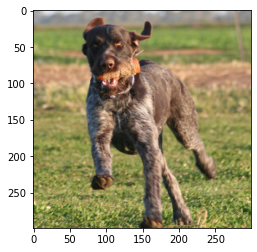

In [ ]:
# generate the captions for a whole batch
model.eval()
with torch.no_grad():
    # dls or validation_loader
    itr = iter(validation_loader)
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] # if idx != 0 and idx != 1 and idx != 2
    print("Original:", ' '.join(s))
    
    # extract features
    print(img[0:1].shape)
    features = model.encoder(img[0:1].to(device))

    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])

In [ ]:
def evaluateModel(mode, dls):
    model.eval()
    
    # to store references and predictions
    y, yhat = list(), list()
    
    # iterate all batches
    for idxx, (img, captions, img_ids) in enumerate(iter(dls)):
        print(idxx)
        with torch.no_grad():
            
            # iterate each record in batch
            for i in range(batch_size):
                
                # if empty record
                if len(captions[i:i+1]) == 0:
                    break
                caption = captions[i:i+1][0].tolist()
                s = [dataset.vocab.itos[idx] for idx in caption if idx != 0] #  and idx != 1 and idx != 2
                
                y.append(descriptors[img_ids[i]])
                features = model.encoder(img[i:i+1].to(device))
                pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

                yhat.append(pred_caps)
                caption = ' '.join(pred_caps)

    # calculate BLEU score
    
    print('BLEU-1: %f' % corpus_bleu(y, yhat, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(y, yhat, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(y, yhat, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(y, yhat, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
evaluateModel(model, validation_loader)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
BLEU-1: 0.594435
BLEU-2: 0.440589
BLEU-3: 0.337126
BLEU-4: 0.197693


In [ ]:
from PIL import Image
import torchvision.transforms.functional as TF
from skimage import io

torch.Size([1, 3, 299, 299])
Predicted: <start> एक युवा लड़की एक सोफे पर बैठी है और एक महिला एक किताब पढ़ रही है। <end>


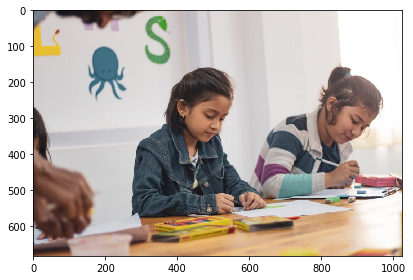

In [ ]:
model.eval()
with torch.no_grad():
    img_="/content/Classroom.jpg"
    img = Image.open(img_)
    img = img.resize((299,299), Image.ANTIALIAS)
    x = TF.to_tensor(img)
    x.unsqueeze_(0)
    # extract features
    print(x.shape)
    features = model.encoder(x[0:1].to(device))
    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=dataset.vocab)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    img = io.imread(img_)
    io.imshow(img)